In [1]:
# uncomment to use a custom environment file
#from dotenv import load_dotenv
#load_dotenv('../mac.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader
from torchvision import tv_tensors

from graphics_and_data_prep import display_images_and_boxes, train_rcnn, mAP_widget


MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Object Detection

In [2]:
mAP_widget()

In this notebook we'll fine-tune a Faster R-CNN model to detect pedestrian in the [Penn-Fudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/).  It consists of 170 images with 345 labeled pedestrians taken on two university campuses.  You should have read the textbook to get an idea of how the Faster R-CNN model works so we'll focus here on two main things.  First, we'll look at the Mean Average Precision (mAP) metric for evaluating how well an objective detection model both identifies and localizes objects.  Second, we'll examine how we can filter out redundant and low-confidence predicted boxes.

<iframe
    width="560"
    height="315"
    src="https://www.youtube.com/embed/FppOzcDvaDI"
    frameborder="0"
    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture"
    allowfullscreen>
</iframe>

In object detection, **Mean Average Precision (mAP)** is a key metric for evaluating how well a model identifies and localizes multiple object types within an image. Here are the core concepts:

### Key Concepts of mAP for Object Detection

1. **Intersection over Union (IoU)**:
   - **IoU** measures the overlap between a predicted bounding box and the ground truth bounding box. It is calculated as:
     \[
     \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
     \]
   - IoU values range from 0 to 1, where values closer to 1 indicate a high overlap, meaning the prediction closely matches the ground truth. IoU thresholds, often 0.5 and 0.75, determine the minimum overlap required for a correct detection.

2. **True Positives (TP), False Positives (FP), and False Negatives (FN)**:
   - A **True Positive** occurs when a predicted bounding box matches a ground truth box with IoU above the threshold.
   - A **False Positive** occurs when a predicted box does not match any ground truth box (IoU below threshold) or detects a non-existent object.
   - A **False Negative** occurs when a ground truth box has no matching predicted box, indicating the model missed detecting an actual object.

3. **Precision and Recall**:
   - **Precision** measures how many of the detected objects are correct, calculated as:
     \[
     \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
     \]
   - **Recall** measures how many actual objects the model detected, calculated as:
     \[
     \text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
     \]
   - Precision and Recall are typically calculated at multiple IoU thresholds (e.g., 0.5, 0.75) to reflect different levels of localization accuracy.

4. **Precision-Recall Curve and Average Precision (AP)**:
   - For each IoU threshold, a **Precision-Recall curve** is plotted by varying the confidence threshold of detections.
   - The **Average Precision (AP)** at each IoU threshold is the area under the Precision-Recall curve, providing a measure of the model’s accuracy at that IoU level.

5. **Mean Average Precision (mAP)**:
   - **mAP** is the mean of AP values across multiple IoU thresholds and classes.
   - In multi-class detection, mAP averages AP across both classes and IoU thresholds, providing a single score representing the model’s overall detection and localization performance across object types.

### Applying mAP to One-Class Detection Problems
In a single-class object detection task (e.g., detecting pedestrians or lesions), mAP still measures localization accuracy and detection reliability but focuses on just one object type. Here’s how mAP applies specifically to single-class detection:

- **Simplified IoU Thresholds**: For single-class problems, a single IoU threshold (e.g., 0.5) can suffice. This is known as mAP@0.5 and indicates the model’s accuracy in detecting and localizing objects of that class at a moderate level of overlap.
- **Single Precision-Recall Curve**: Instead of averaging AP across classes, a single Precision-Recall curve is created for the one object class. The AP value from this curve reflects the model’s detection accuracy for the class.
- **Interpretability**: A higher mAP score (closer to 1) means the model consistently detects and localizes instances of the single class with minimal false positives and missed detections, simplifying performance interpretation compared to multi-class problems.

**Intuitive Explanation for mAP:**

mAP, or mean Average Precision, measures how well a model detects objects by considering both **precision** (accuracy of predictions) and **recall** (coverage of ground truth objects). In essence, mAP tells you how well the model balances detecting **all instances** of an object while also keeping **false positives** (incorrect detections) low.

In a single-class problem, mAP captures how accurately and consistently the model detects objects of that class across different confidence thresholds. A high mAP means the model is good at finding and correctly classifying instances of the object.

**What mAP@50 and mAP@50:95 Mean for a Single-Class Problem:**

- **mAP@50**: This calculates the model's precision and recall at an Intersection over Union (IoU) threshold of 0.5. In simpler terms, a detection counts as correct if it overlaps with the ground truth by at least 50%. So, mAP@50 measures the model's ability to find objects without being overly strict about the exact position and size of the bounding box.

- **mAP@50:95**: This is a stricter metric that averages the mAP across IoU thresholds from 0.5 to 0.95 in steps of 0.05 (0.5, 0.55, …, 0.95). Here, the model needs to get closer to the actual object boundary to achieve a high score, making mAP@50:95 a more challenging but comprehensive measure of detection accuracy. It requires the model not just to detect objects but also to have precise bounding box localization.

In a single-class problem, mAP@50 gives a good indication of basic detection performance, while mAP@50:95 is more demanding and reflects both detection and precise localization quality.

In [32]:
class PennFudanDetect(Dataset):
    """
    Custom Dataset for Penn-Fudan Database for Pedestrian Detection.
    Args:
        root (str or Path): Root directory of the dataset.
        transforms (callable, optional): A function/transform that takes in an image and target and returns a transformed version.
        split (str, optional): Dataset split, either 'train' or 'val'. Default is 'train'.
        seed (int, optional): Random seed for shuffling the dataset. Default is 42.
    Attributes:
        imgs (list): List of image file paths.
        masks (list): List of mask file paths.
        split (str): Dataset split, either 'train' or 'val'.
        seed (int): Random seed for shuffling the dataset.
    Methods:
        __getitem__(idx):
            Args:
                idx (int): Index of the item to be fetched.
            Returns:
                tuple: (image, target) where target is a dictionary containing 'boxes' and 'labels'.
        __len__():
            Returns:
                int: Number of items in the dataset.
    """
    def __init__(self, root, transforms=None, split='train', seed=42):
        self.root = Path(root)
        self.transforms = transforms
        self.split = split
        self.seed = seed

        # Load all image and mask files
        imgs = sorted((self.root / "PNGImages").iterdir())
        masks = sorted((self.root / "PedMasks").iterdir())

        # Ensure reproducibility with a fixed seed
        indices = list(range(len(imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

        # Assign the split based on the parameter
        if split == 'train':
            self.indices = train_indices
        elif split == 'val':
            self.indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        # Subset the images and masks according to the split
        self.imgs = [imgs[i] for i in self.indices]
        self.masks = [masks[i] for i in self.indices]

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = read_image(str(img_path)).float() / 255.0  # Normalize to [0, 1]
        mask = read_image(str(mask_path))

        # Prepare masks and bounding boxes
        obj_ids = torch.unique(mask)[1:]  # Exclude background (first ID)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # Single class

        # Create tv_tensor types
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:]),
            "labels": labels,
        }

        # Apply transformations
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [13]:
# Define training transformations
train_transforms = T.Compose([
    T.RandomHorizontalFlip(0.5),  # Random horizontal flip with 50% probability
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color jitter
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Define validation transformations (no data augmentation, just tensor conversion)
val_transforms = T.Compose([
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanDetect(root=dataset_path, split='train', transforms=train_transforms)
val_dataset = PennFudanDetect(root=dataset_path, split='val', transforms=val_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

# define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
# model configuration
save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone_name = 'resnet50' 
weights = "DEFAULT"

backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # MPS doesn't work with Faster R-CNN
model.to(device)

# training configuration
initial_lr = 0.005  # Initial learning rate
weight_decay = 0.0005
patience = 5  # Early stopping patience

# Training parameters
num_epochs = 15
patience = 3

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Example usage
results = train_rcnn(model, optimizer, scheduler, train_loader, val_loader, device, save_file=save_path, num_epochs=15, patience=5)



KeyboardInterrupt: 

In [5]:
results

,epoch,train_loss,val_loss,map_50,map_50_95,lr
0,1,0.418014,0.330351,0.470669,0.242354,0.005
1,2,0.258505,0.219362,0.795052,0.469431,0.005
2,3,0.204865,0.187340,0.821444,0.517866,0.005
3,4,0.172139,0.175337,0.951965,0.660241,0.005
4,5,0.169452,0.156109,0.960251,0.706611,0.005
5,6,0.152757,0.174190,0.966357,0.777474,0.005
6,7,0.149275,0.145241,0.946430,0.762012,0.005
7,8,0.138271,0.178512,0.951674,0.796866,0.005
8,9,0.136087,0.148131,0.982742,0.880750,0.005
9,10,0.128542,0.158729,0.949091,0.799144,0.005


In [11]:

model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights="DEFAULT")
model = FasterRCNN(backbone, num_classes=2)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu'), weights_only=True));
model.eval();

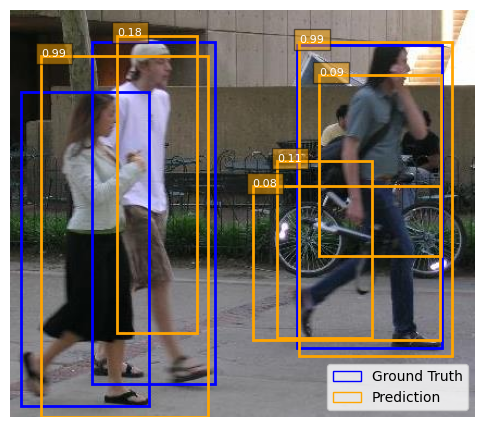

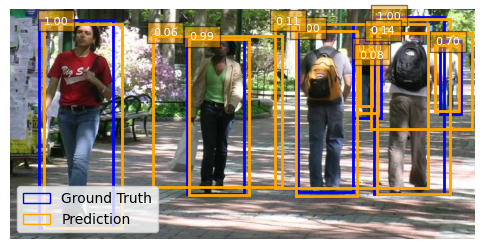

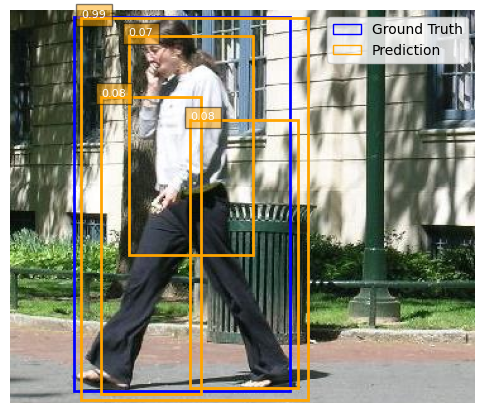

In [12]:
# Display random samples with ground truth and predictions with no filtering
selected_images = [0,4,6]
display_images_and_boxes(val_dataset, model=model, indices=selected_images,denormalize=False, 
                         min_confidence=0.0, iou_max_overlap=1.0, show_confidence=True)

### Performs Non-Maximum Suppression (NMS) and confidence filtering for object detection.

Non-Maximum Suppression (NMS):
NMS is a technique used to eliminate redundant or overlapping bounding boxes in object detection. 
It selects the bounding box with the highest confidence score and suppresses all other boxes that 
have a high overlap (Intersection over Union, IoU) with the selected box. This helps in reducing 
multiple detections of the same object.

Confidence Filtering:
Confidence filtering involves removing bounding boxes that have a confidence score below a certain 
threshold. This helps in eliminating low-confidence detections, thereby improving the precision 
of the object detection model.

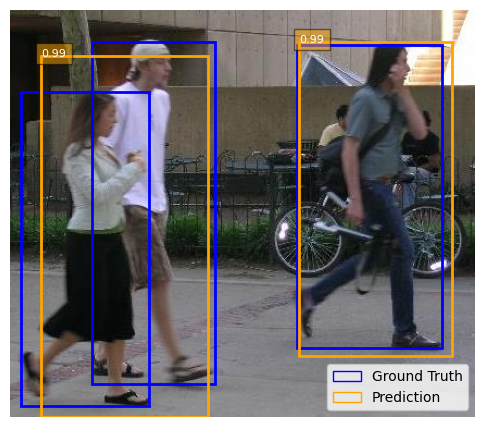

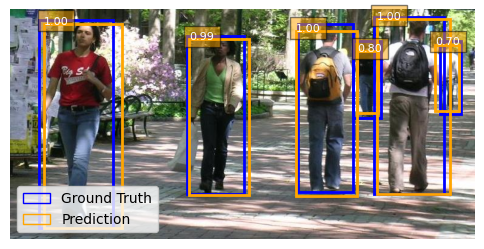

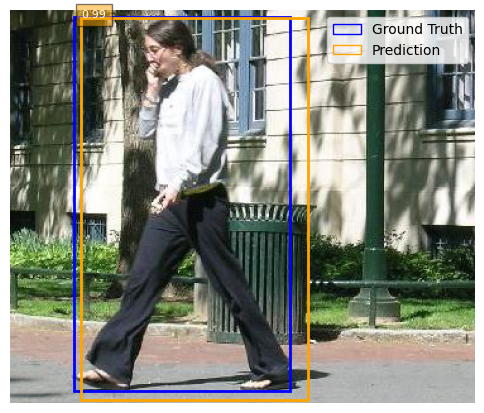

In [13]:
# Display random samples with ground truth and predictions with no filtering
display_images_and_boxes(val_dataset, model=model, indices=selected_images, min_confidence=.5, iou_max_overlap = 0.4, denormalize=False, show_confidence=True)

# Develop Fancy Display

In [12]:
# Load image and annotations
image = read_image("./pictures/stick_peds.png")
gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores = load_annotations("./pictures/stick_peds.json")

# Display image with interactive sliders and adjustable font sizes
display_image_with_dropdown(image, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)
